Copyright (C) Jędrzej Kubica, Nicolas Thierry-Mieg, 2024-2025

This file was written by Jędrzej Kubica and Nicolas Thierry-Mieg
(CNRS, France) Nicolas.Thierry-Mieg@univ-grenoble-alpes.fr

This program is free software: you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the Free Software
Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY;
without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program.
If not, see <https://www.gnu.org/licenses/>.

## The validation notebook for GBA centrality

- **Part 1: Tissue-enrichment validation**

    We compare the ratio of predicted causal genes enriched in the expected tissues with the ratio using Fisher's exact test:

    Part 1.1. GBA centrality
    
    Part 1.2. Random Walk with Restart (RWR)

    Part 1.3. Comparison of tissue enrichment: GBA centrality vs RWR

- **Part 2: Leave-one-out cross-validation**

    Part 2.1. Compare empirical CDFs (cumulative distributions) for left-out gene ranks in GBA centrality and RWR using the Wilcoxon signed-rank test.

    Part 2.2. Compare ranks vs degrees for left-out genes in GBA centrality and RWR, all phenotypes combined.

In [45]:
import sys

import scipy
import numpy
import networkx
import statistics

import matplotlib.pyplot
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sys.path.append("/home/kubicaj/Software/GBA-centrality")
import data_parser

In [46]:
def parse_uniprot(uniprot_file):
    """
    Parses a tab-seperated Uniprot file produced by GBA_centrality/Interactome/uniprot_parser.py
    with 7 columns (one record per line):
    - Uniprot Primary Accession
    - Taxonomy Identifier
    - ENST (or a comma seperated list of ENSTs)
    - ENSG (or a comma seperated list of ENSGs)
    - Uniprot Secondary Accession (or a comma seperated list of Uniprot Secondary Accessions)
    - GeneID (or a comma seperated list of GeneIDs)
    - Gene Name (or a comma seperated list of Gene Names)

    Returns:
      - ENSG2gene: dict with key=ENSG, value=geneName
      - uniprot2ENSG: dict with key=Primary accession, value=ENSG

    Note: if more than one gene name is associated with a particular ENSG,
          then keeping the first gene name from the list
    """
    ENSG2gene = {}
    uniprot2ENSG = {}

    try:
        f = open(uniprot_file, 'r')
    except Exception as e:
        raise Exception("cannot open provided Uniprot file %s: %s", uniprot_file, e)

    # skip header
    line = f.readline()
    if not line.startswith("Primary_AC\t"):
        raise Exception("uniprot file %s is headerless? expecting headers but got %s",
                      uniprot_file, line)

    for line in f:
        split_line = line.rstrip('\r\n').split('\t')

        # if some records are incomplete, die
        if len(split_line) != 7:
            raise Exception("uniprot file %s line doesn't have 7 fields: %s",
                          uniprot_file, line)

        (AC_primary, TaxID, ENSTs, ENSGs, AC_secondary, GeneIDs, geneNames) = split_line

        # make sure there is at least one ENSG and keep only the first one
        if ENSGs == "":
            continue
        ENSG = ENSGs.split(',')[0]

        # make sure there is at least one gene name and keep only the first one
        if geneNames == "":
            continue
        geneName = geneNames.split(',')[0]

        ENSG2gene[ENSG] = geneName
        uniprot2ENSG[AC_primary] = ENSG

    return(ENSG2gene, uniprot2ENSG)

In [47]:
def parse_scores(scores_file):
    """
    Loads the scores generated with GBA_centrality.py
    
    returns:
    - node2score: dict with key=node, value=score
    """
    node2score = {}

    try:
        f = open(scores_file, 'r')
    except Exception as e:
        raise Exception("cannot open provided scores file")

    line = f.readline()
    if not line.startswith("NODE\t"):
        raise Exception("Scores file problem")

    for line in f:
        split_line = line.rstrip().split('\t')
        node, score = split_line

        node2score[node] = float(score)

    return(node2score)

In [48]:
def parse_RWR_scores(scores_file):
    """
    Loads the scores generated with MultiXrank
    
    returns:
    - node2score: dict with key=node, value=score
    """
    node2score = {}

    try:
        f = open(scores_file, 'r')
    except Exception as e:
        raise Exception("cannot open provided scores file")

    line = f.readline()
    if not line.startswith("multiplex\t"):
        raise Exception("Scores file problem")
 
    for line in f:
        split_line = line.rstrip().split('\t')
        multiplex, node, score = split_line

        node2score[node] = float(score)

    return(node2score)

In [49]:
def parse_expression_data(expression_data):
    """
    Loads a TSV file with columns: ENSG\tgene_expression_ratio
    NOTE: we downloaded the Expression Atlas from Ensembl reference (v104)
    then we added manually a column (after the "ENSG" column) called "tissue_enrichment",
    which corresonds to the tissue enrichment of each gene

    returns:
    - ENSG2enrichment: dict, key=ENSG, value=tissue_enrichment
    """
    ENSG2enrichment = {}

    try:
        f = open(expression_data, 'r')
    except Exception as e:
        raise Exception("cannot open provided expression file")

    line = f.readline()
    if not line.startswith("# Expression Atlas\t"):
        raise Exception("Expression file problem")
        
    for line in f:
        # skip comments
        if line.startswith("#"):
            continue

        # skip header
        if line.startswith("Gene"):
            continue

        split_line = line.rstrip().split('\t', maxsplit=2)
        ENSG, tissue_ratio, _ = split_line

        ENSG2enrichment[ENSG] = float(tissue_ratio)
    
    return(ENSG2enrichment)

In [50]:
def take_top_percent(list, x):
    """
    Finds the top x% of values in a list
    
    returns: 
    - top: list with top x% of values
    - rest: list with the rest of values
    """
    num_elements = round(len(list) * x/100)

    top = list[:num_elements]
    rest = list[num_elements:]
    
    return(top, rest)

In [51]:
def intersection(list_1, list_2):
    """
    Returns a list with common elements for two lists
    """
    return list(set(list_1) & set(list_2))

In [52]:
def format_pvalue(pvalue):
    """
    Returns the p-value in the scientific notation, eg 1.00e-2**
    """
    p = '{:.2e}'.format(pvalue)

    if pvalue <= 0.0001:
        return "p < 10^-4****"
    elif pvalue <= 0.001:
        return "p < 10^-3***"
    elif pvalue <= 0.01:
        return "p < 0.01**"
    elif pvalue <= 0.05:
        return "p < 0.05*"    
    return f"p = {p}"

In [53]:
def AUC(values):
    """
    Calculate normalized AUC for the list
    """
    auc = 0.0
    for i in range(1, len(values)):
        auc += (values[i] + values[i-1]) / 2


    max_possible = (len(values) - 1) * max(values)
    auc_norm = auc / max_possible

    return(auc_norm)

### Set parameters and paths

In [54]:
"""Set parameters with which GBA_centrality.py was run"""
PHENOTYPE = "MMAF"
ALPHA = 0.5
alpha = str(ALPHA).replace('.', '')
WEIGHTED = False
DIRECTED = False

In [55]:
"""Set path for output figures if needed"""
SAVE_FIGURES = False
FIGURES_DIR = "./figures/"

In [56]:
UNIPROT_FILE = "/home/kubicaj/GBA-input/uniprot_parsed.tsv"

INTERACTOME_FILE = "/home/kubicaj/GBA-input/interactome_human.sif"

RESULTS_FILE = f"/home/kubicaj/GBA-output/{PHENOTYPE}/alpha{alpha}/scores.tsv"
LEAVE_ONE_OUT_FILE = f"/home/kubicaj/GBA-output/{PHENOTYPE}/alpha{alpha}/scores_LOO.tsv"
LEAVE_ONE_OUT_RANKS_FILE = f"/home/kubicaj/GBA-output/{PHENOTYPE}/alpha{alpha}/ranks_LOO.tsv"

RESULTS_RWR_FILE = f"/home/kubicaj/GBA-centrality-validation/run_MultiXrank/{PHENOTYPE}/output_{PHENOTYPE}/multiplex_1.tsv"
LEAVE_ONE_OUT_RWR_RANKS_FILE = f"/home/kubicaj/GBA-centrality-validation/run_MultiXrank/{PHENOTYPE}/RWR_ranks_LOO.tsv"

In [57]:
"""Data and parameters for Part 1: Tissue-enrichment validation"""
PRED_CAUSAL_DEF = 10  # [%]
TISSUE_ENRICHED_DEF = 10  # [%]

if PHENOTYPE in ["MMAF", "NOA", "OG", "PCD", "POF"]:
    TISSUE = "testis"
elif PHENOTYPE == "BC":
    TISSUE = "breast"
elif PHENOTYPE == "CC":
    TISSUE = "colon"
elif PHENOTYPE in ["HYPCARD", "DILCARD"]:
    TISSUE = "heart"

# see README for the description of GTEx data
GTEX_DATA_FILE = f"./data/E-MTAB-5214-query-results-{TISSUE}-ratio.tpms.csv"

### Load data

In [58]:
"""Parse Uniprot protein-to-gene mapping"""
(ENSG2gene, uniprot2ENSG) = parse_uniprot(UNIPROT_FILE)

In [59]:
"""Parse interactome and construct interactome: networkx Graph"""
(edge_list, node2idx, idx2node) = data_parser.parse_network(network_file=INTERACTOME_FILE, weighted=WEIGHTED, directed=DIRECTED)

edge_list_no_weights = []
for edge in edge_list:
    edge_list_no_weights.append((idx2node[edge[0]], idx2node[edge[1]]))
interactome = networkx.from_edgelist(edge_list_no_weights)

print(f"Interactome: {len(interactome.nodes())} proteins, {len(interactome.edges())} interactions")

Interactome: 17780 proteins, 370096 interactions


In [60]:
"""Calculate the mean and median degree of proteins in the interactome"""
interactome_degrees = []

for protein in interactome.nodes():
    interactome_degrees.append(interactome.degree(protein))

print(f"interactome node degree mean: {round(statistics.mean(interactome_degrees))}, median: {round(statistics.median(interactome_degrees))}")

interactome node degree mean: 42, median: 16


In [61]:
"""Load GBA centrality scores and leave-one-out results, then sort them by descending order"""
protein2score_all = parse_scores(RESULTS_FILE)
protein2score_leaveOneOut = parse_scores(LEAVE_ONE_OUT_FILE)

protein2score = protein2score_all.copy()

# remove seeds from results
for protein in protein2score_leaveOneOut:
    del protein2score[protein]

results_sorted = sorted(protein2score.keys(), key=lambda item: protein2score[item], reverse=True)
scores_sorted = [protein2score[node] for node in results_sorted]

results_leave_one_out_sorted = sorted(protein2score_leaveOneOut.keys(),
                                      key=lambda item: protein2score_leaveOneOut[item],
                                      reverse=True)
scores_leave_one_out_sorted = [protein2score_leaveOneOut[node] for node in results_leave_one_out_sorted]

In [62]:
"""Calculate the mean and median degree of seeds"""
causal_degrees = []
for protein in protein2score_leaveOneOut:
    causal_degrees.append(interactome.degree(protein))

print(f"{PHENOTYPE} node degree mean {round(statistics.mean(causal_degrees))}, median {round(statistics.median(causal_degrees))}")

MMAF node degree mean 25, median 10


### Part 1: Tissue-enrichment validation

#### Part 1.1. Tissue-enrichment validation: GBA centrality

In [63]:
"""Load tissue expression data"""
ENSG2enrichment = parse_expression_data(GTEX_DATA_FILE)

protein2enrichment = {}
for protein in interactome:
    if protein in uniprot2ENSG:
        ENSG = uniprot2ENSG[protein]
        # due to obsolete GTEx data, some genes in the interactome need
        # to be removed from the tissue enrichment analysis
        if ENSG in ENSG2enrichment:
            protein2enrichment[protein] = ENSG2enrichment[ENSG]

In [64]:
"""Get top x% of highest-scoring genes (including causal)"""
# due to obsolete GTEx data, some genes in the interactome need to be removed from the tissue enrichment analysis
for protein in interactome:
    if protein not in protein2enrichment:
        del protein2score_all[protein]

results_all_sorted = sorted(protein2score_all.keys(), key=lambda item: protein2score_all[item], reverse=True)
pred_causal, non_pred_causal = take_top_percent(results_all_sorted, PRED_CAUSAL_DEF)

print(f"Selected {len(pred_causal)} higest-scoring genes")

Selected 1708 higest-scoring genes


In [65]:
"""Get top x% of genes enriched in the tissue"""
tissue_expr_sorted = sorted(protein2enrichment.keys(), key=lambda item: protein2enrichment[item], reverse=True)
tissue_enriched, non_tissue_enriched = take_top_percent(tissue_expr_sorted, TISSUE_ENRICHED_DEF)

print(f"Selected {len(tissue_enriched)} {TISSUE}-enriched genes")

Selected 1708 testis-enriched genes


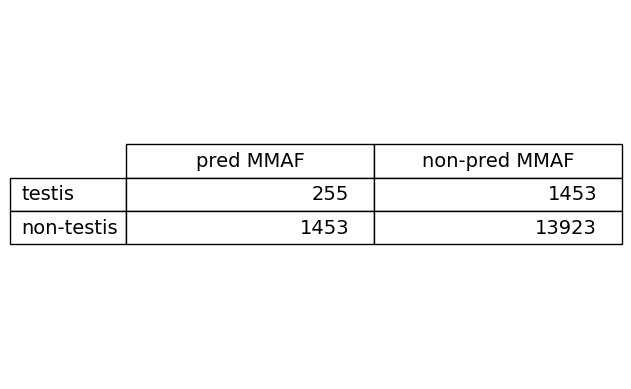

In [66]:
"""Construct a contingency matrix for Fisher's exact test"""
x1 = len(intersection(pred_causal, tissue_enriched))
x2 = len(intersection(non_pred_causal, tissue_enriched))
x3 = len(intersection(pred_causal, non_tissue_enriched))
x4 = len(intersection(non_pred_causal, non_tissue_enriched))

contingency_matrix = [[x1, x2], [x3, x4]]

# plot the contingency table
fig, ax = matplotlib.pyplot.subplots()
table = ax.table(contingency_matrix, 
                 rowLabels=[f'{TISSUE}', f'non-{TISSUE}'], 
                 colLabels=[f'pred {PHENOTYPE}', f'non-pred {PHENOTYPE}'], 
                 loc="center")
ax.axis('tight')
ax.axis('off')
table.set_fontsize(14)
table.scale(1,2)

In [67]:
""" 
Check if the ratio of predicted causal genes enriched in tissue is greater 
than the ratio of all genes enriched in the tissue

Note: alternative='greater' is the probability that a random table has x >= a, 
where contingency_matrix = [[a, b], [c, d]]
"""
_, p_tissue_expr = scipy.stats.fisher_exact(contingency_matrix, alternative='greater')

p_tissue_expr = format_pvalue(pvalue=p_tissue_expr)
print(f"{p_tissue_expr}")

p < 10^-4****


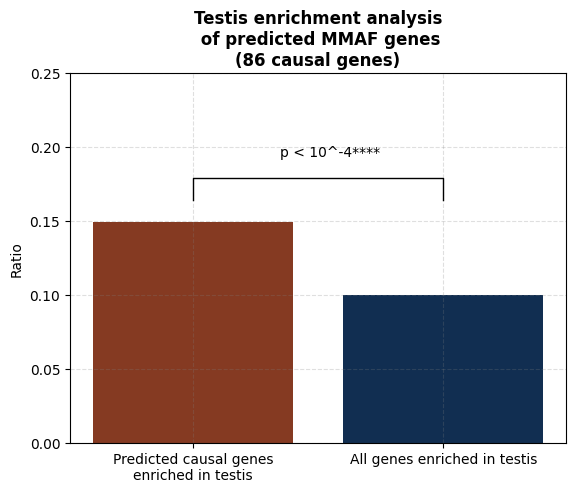

In [68]:
proportion1 = x1 / (x1 + x3)  # ratio of predicted causal genes that are enriched in tissue
proportion2 = (x1 + x2) / (x1 + x2 + x3 + x4)  # ratio of all genes that are enriched in tissue

labels = [f"Predicted causal genes\nenriched in {TISSUE}", 
          f"All genes enriched in {TISSUE}"]

matplotlib.pyplot.bar(x=labels, height=[proportion1, proportion2], color=['#853A22', '#112E51'])

# if statements below are convenient for plotting
if PHENOTYPE in ["MMAF", "NOA", "OG", "PCD", "POF"]:
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted {PHENOTYPE} genes\n({len(protein2score_leaveOneOut)} causal genes)", weight='bold', fontsize=12)
elif PHENOTYPE == "BC":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted breast cancer genes\n({len(protein2score_leaveOneOut)} causal genes)", weight='bold', fontsize=12)
elif PHENOTYPE == "CC":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted colon cancer genes\n({len(protein2score_leaveOneOut)} causal genes)", weight='bold', fontsize=12)
elif PHENOTYPE == "HYPCARD":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted hypertrophic cardiomyopathy genes\n({len(protein2score_leaveOneOut)} causal genes)", weight='bold', fontsize=12)
elif PHENOTYPE == "DILCARD":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted dilated cardiomyopathy genes\n({len(protein2score_leaveOneOut)} causal genes)", weight='bold', fontsize=12)

# plot p-value
h = .1 * max(proportion1, proportion2)
y = max(proportion1, proportion2) + h

matplotlib.pyplot.plot([labels[0], labels[0], labels[1], labels[1]], [y, y+h, y+h, y], lw=1, c='black')
matplotlib.pyplot.text(x=0.35,y=y+2*h, s=f"{p_tissue_expr}")

y_max = 2*max(proportion1, proportion2)
matplotlib.pyplot.yticks(numpy.arange(0, y_max, 0.05))
matplotlib.pyplot.ylabel("Ratio")

matplotlib.pyplot.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)

if SAVE_FIGURES:
    matplotlib.pyplot.savefig(FIGURES_DIR + f"{PHENOTYPE}_tissue_enrichment_GBA", dpi=1000)

#### Part 1.2. Tissue-enrichment validation: RWR

In [72]:
"""Load MultiXrank (RWR) scores and leave-one-out results"""
protein2score_RWR = parse_RWR_scores(RESULTS_RWR_FILE)

In [73]:
"""Get top x% of highest-scoring genes (including causal)"""
# due to obsolete GTEx data, some genes in the interactome need to be removed from the tissue enrichment analysis
for gene in interactome:
    if gene not in protein2enrichment:
        del protein2score_RWR[gene]

results_RWR_sorted = sorted(protein2score_RWR.keys(), key=lambda item: protein2score_RWR[item], reverse=True)
pred_causal_RWR, non_pred_causal_RWR = take_top_percent(results_RWR_sorted, PRED_CAUSAL_DEF)

print(f"Selected {len(pred_causal_RWR)} higest-scoring genes")

Selected 1708 higest-scoring genes


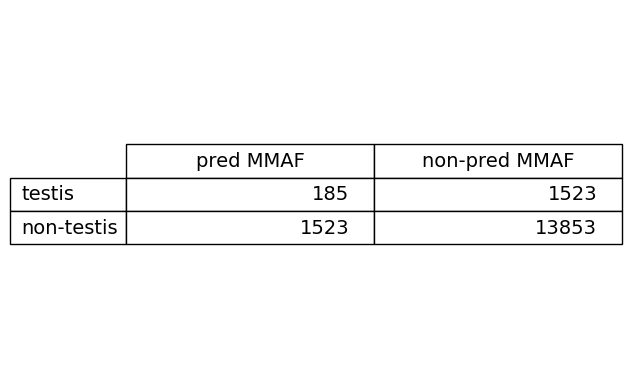

In [74]:
"""Construct a contingency matrix for Fisher's exact test"""
x1 = len(intersection(pred_causal_RWR, tissue_enriched))
x2 = len(intersection(non_pred_causal_RWR, tissue_enriched))
x3 = len(intersection(pred_causal_RWR, non_tissue_enriched))
x4 = len(intersection(non_pred_causal_RWR, non_tissue_enriched))

contingency_matrix = [[x1, x2], [x3, x4]]

# plot the contingency table
fig, ax = matplotlib.pyplot.subplots()
table = ax.table(contingency_matrix, 
                 rowLabels=[f'{TISSUE}', f'non-{TISSUE}'], 
                 colLabels=[f'pred {PHENOTYPE}', f'non-pred {PHENOTYPE}'], 
                 loc="center")
ax.axis('tight')
ax.axis('off')
table.set_fontsize(14)
table.scale(1,2)

In [75]:
""" 
Check if the ratio of predicted causal genes enriched in the tissue is greater 
than the ratio of all genes enriched in the tissue

Note: alternative='greater' is the probability that a random table has x >= a, 
where contingency_matrix = [[a, b], [c, d]]
"""
_, p_tissue_expr = scipy.stats.fisher_exact(contingency_matrix, alternative='greater')

p_tissue_expr = format_pvalue(pvalue=p_tissue_expr)
print(f"{p_tissue_expr}")

p = 1.22e-01


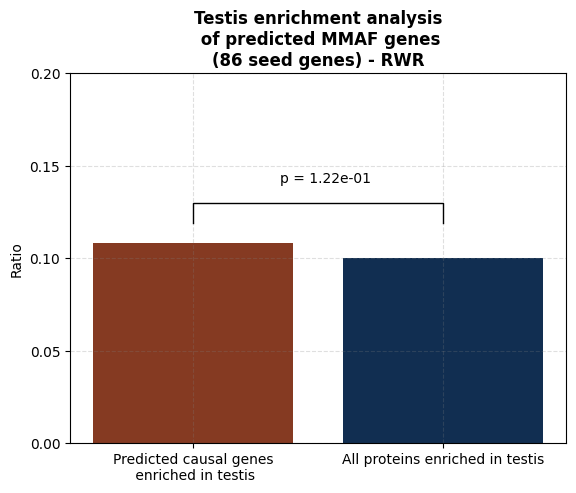

In [76]:
proportion1 = x1 / (x1 + x3)  # ratio of predicted causal genes that are enriched in tissue
proportion2 = (x1 + x2) / (x1 + x2 + x3 + x4)  # ratio of all genes that are enriched in tissue

labels = [f"Predicted causal genes\n enriched in {TISSUE}", 
          f"All proteins enriched in {TISSUE}"]

matplotlib.pyplot.bar(x=labels, height=[proportion1, proportion2], color=['#853A22', '#112E51'])

# if statements below are convenient for plotting
if PHENOTYPE in ["MMAF", "NOA", "OG", "PCD", "POF"]:
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted {PHENOTYPE} genes\n({len(protein2score_leaveOneOut)} seed genes) - RWR", weight='bold', fontsize=12)
elif PHENOTYPE == "BC":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted breast cancer genes\n({len(protein2score_leaveOneOut)} causal genes) - RWR", weight='bold', fontsize=12)
elif PHENOTYPE == "CC":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted colon cancer genes\n({len(protein2score_leaveOneOut)} causal genes) - RWR", weight='bold', fontsize=12)
elif PHENOTYPE == "HYPCARD":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted hypertrophic cardiomyopathy genes\n({len(protein2score_leaveOneOut)} causal genes) - RWR", weight='bold', fontsize=12)
elif PHENOTYPE == "DILCARD":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted dilated cardiomyopathy genes\n({len(protein2score_leaveOneOut)} causal genes) - RWR", weight='bold', fontsize=12)

# plot p-value
h = .1 * max(proportion1, proportion2)
y = max(proportion1, proportion2) + h

matplotlib.pyplot.plot([labels[0], labels[0], labels[1], labels[1]], [y, y+h, y+h, y], lw=1, c='black')
matplotlib.pyplot.text(x=0.35,y=y+2*h, s=f"{p_tissue_expr}")

y_max = 2*max(proportion1, proportion2)
matplotlib.pyplot.yticks(numpy.arange(0, y_max, 0.05))
matplotlib.pyplot.ylabel("Ratio")

matplotlib.pyplot.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)

if SAVE_FIGURES:
    matplotlib.pyplot.savefig(FIGURES_DIR + f"{PHENOTYPE}_tissue_enrichment_RWR", dpi=1000)

#### Part 1.4. Comparison of tissue enrichment: GBA centrality vs RWR

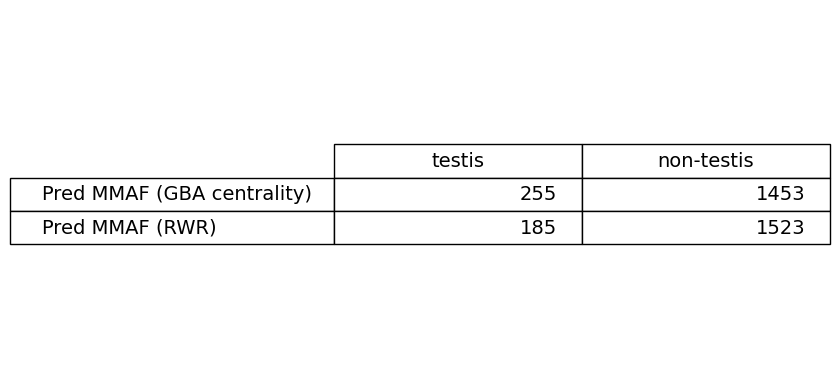

In [77]:
"""Construct a contingency matrix for Fisher's exact test to compare GBA centrality and RWR"""
x1 = len(intersection(pred_causal, tissue_enriched))
x2 = len(intersection(pred_causal, non_tissue_enriched))
x3 = len(intersection(pred_causal_RWR, tissue_enriched))
x4 = len(intersection(pred_causal_RWR, non_tissue_enriched))

contingency_matrix = [[x1, x2], [x3, x4]]

# plot the contingency table
fig, ax = matplotlib.pyplot.subplots()
table = ax.table(contingency_matrix, 
                 rowLabels=[f'Pred {PHENOTYPE} (GBA centrality)', f'Pred {PHENOTYPE} (RWR)'], 
                 colLabels=[f'{TISSUE}', f'non-{TISSUE}'], 
                 loc="center")
ax.axis('tight')
ax.axis('off')
table.set_fontsize(14)
table.scale(1,2)

In [78]:
""" 
Check if the ratio of predicted causal genes enriched in the tissue is greater
for GBA centrality than for RWR

Note: alternative='greater' is the probability that a random table has x >= a, 
where contingency_matrix = [[a, b], [c, d]]
"""
_, p_tissue_expr = scipy.stats.fisher_exact(contingency_matrix, alternative='greater')

p_tissue_expr = format_pvalue(pvalue=p_tissue_expr)
print(f"{p_tissue_expr}")

p < 10^-3***


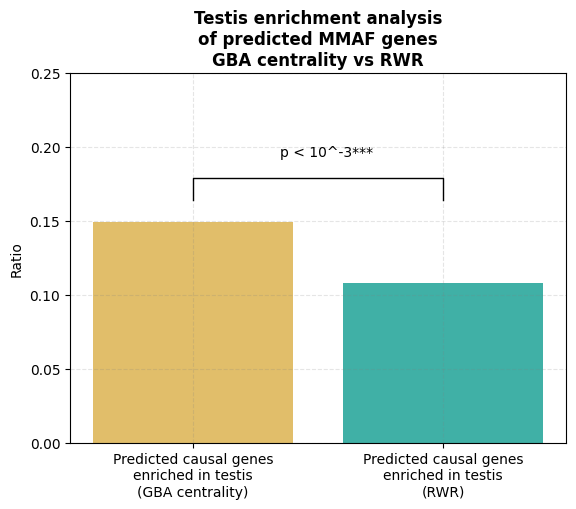

In [79]:
proportion1 = x1 / (x1 + x2)  # ratio of predicted causal genes that are tissue-enriched (GBA centrality)
proportion2 = x3 / (x3 + x4)  # ratio of predicted causal genes that are tissue-enriched (RWR)

labels = [f"Predicted causal genes\nenriched in {TISSUE}\n(GBA centrality)", 
          f"Predicted causal genes\nenriched in {TISSUE}\n(RWR)"]

matplotlib.pyplot.bar(x=labels, height=[proportion1, proportion2], color=['#E1BE6A', '#40B0A6'])

# if statements below are convenient for plotting
if PHENOTYPE in ["MMAF", "NOA", "OG", "PCD", "POF"]:
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\nof predicted {PHENOTYPE} genes\nGBA centrality vs RWR", weight='bold', fontsize=12)
elif PHENOTYPE == "BC":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\nof predicted breast cancer genes\nGBA centrality vs RWR", weight='bold', fontsize=12)
elif PHENOTYPE == "CC":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\nof predicted colon cancer genes\nGBA centrality vs RWR", weight='bold', fontsize=12)
elif PHENOTYPE == "HYPCARD":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\nof predicted hypertrophic cardiomyopathy genes\nGBA centrality vs RWR", weight='bold', fontsize=12)
elif PHENOTYPE == "DILCARD":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\nof predicted dilated cardiomyopathy genes\nGBA centrality vs RWR", weight='bold', fontsize=12)

# plot p-value
h = .1 * max(proportion1, proportion2)
y = max(proportion1, proportion2) + h

matplotlib.pyplot.plot([labels[0], labels[0], labels[1], labels[1]], [y, y+h, y+h, y], lw=1, c='black')
matplotlib.pyplot.text(x=0.35,y=y+2*h, s=f"{p_tissue_expr}")

y_max = 2*max(proportion1, proportion2)
matplotlib.pyplot.yticks(numpy.arange(0, y_max, 0.05))
matplotlib.pyplot.ylabel("Ratio")

matplotlib.pyplot.grid(True, linestyle='--', which='major',
                   color='grey', alpha=0.2)

if SAVE_FIGURES:
    matplotlib.pyplot.savefig(FIGURES_DIR + f"{PHENOTYPE}_tissue_enrichment_GBA_vs_RWR", dpi=1000)

### Part 2: Leave-one-out validation

In [80]:
def parse_GBA_ranks(ranks_file):
    """
    Loads the ranks generated with run_GBA_centrality/leave_one_out.py --ranks
    Returns:
    - node2rank: dict with key=node, value=rank
    """
    node2rank = {}

    try:
        f = open(ranks_file, 'r')
    except Exception as e:
        raise Exception("cannot open provided ranks file")

    line = f.readline()
    if not line.startswith("NODE\t"):
        raise Exception("Ranks file problem")

    for line in f:
        split_line = line.rstrip().split('\t')

        node, rank = split_line

        node2rank[node] = int(rank)

    return(node2rank)

In [81]:
def parse_RWR_ranks(ranks_file):
    """
    Loads the ranks generated with run_MultiXrank/run_leave_one_out.py
    Returns:
    - node2rank: dict with key=node, value=rank
    """
    node2rank = {}

    try:
        f = open(ranks_file, 'r')
    except Exception as e:
        raise Exception("cannot open provided ranks file")

    for line in f:
        split_line = line.rstrip().split('\t')
        node, rank = split_line
        node2rank[node] = int(rank)

    return(node2rank)

#### Part 2.1. CDFs

In [82]:
protein2rank_GBA = parse_GBA_ranks(LEAVE_ONE_OUT_RANKS_FILE)
protein2rank_RWR = parse_RWR_ranks(LEAVE_ONE_OUT_RWR_RANKS_FILE)

In [83]:
ranks_RWR = []
ranks_GBA = []

for gene in protein2rank_RWR:
    ranks_RWR.append(protein2rank_RWR[gene])
    ranks_GBA.append(protein2rank_GBA[gene])

In [84]:
# generate ranks with a random classifier
# use the integers method of a Generator instance instead of numpy.random.randint
# https://numpy.org/doc/2.1/reference/random/generated/numpy.random.randint.html
rng = numpy.random.default_rng()

# 1D numpy array for left-out known causal gene ranks
# size=len(left-out genes)
ranks_random = numpy.zeros(len(protein2rank_RWR), dtype=numpy.uint64)

n = 10000
for i in range(n):
    # 1D numpy array for left-out gene ranks
    # size=len(left-out genes)
    tmp = rng.integers(low=1, high=len(interactome), size=ranks_random.shape, dtype=numpy.uint64)
    tmp = numpy.sort(tmp)
    ranks_random += tmp

for j in range(len(ranks_random)):
    avg_rank = ranks_random[j] / n
    ranks_random[j] = avg_rank

In [85]:
curve_RWR = []
curve_GBA = []
curve_random = []

for i in range(len(interactome)):
    curve_RWR.append(sum(rank <= i for rank in ranks_RWR))
    curve_GBA.append(sum(rank <= i for rank in ranks_GBA))
    curve_random.append(sum(rank <= i for rank in ranks_random))

In [86]:
AUC_GBA = AUC(curve_GBA)
AUC_RWR = AUC(curve_RWR)
print("AUC GBA: {:.3f}".format(AUC_GBA))
print("AUC RWR: {:.3f}".format(AUC_RWR))

AUC GBA: 0.712
AUC RWR: 0.542


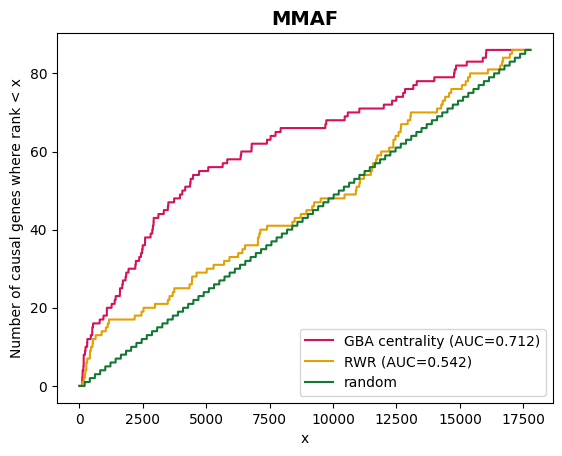

In [87]:
matplotlib.pyplot.plot(range(len(interactome)), curve_GBA, label="GBA centrality (AUC={:.3f})".format(AUC_GBA), color="#D41159")
matplotlib.pyplot.plot(range(len(interactome)), curve_RWR, label="RWR (AUC={:.3f})".format(AUC_RWR), color="#E69F00")
matplotlib.pyplot.plot(range(len(interactome)), curve_random, label="random", color="#117733")

# if statements below are convenient for plotting
if PHENOTYPE in ["MMAF", "NOA", "OG", "PCD", "POF"]:
    matplotlib.pyplot.title(f"{PHENOTYPE}", weight='bold', fontsize=14)
elif PHENOTYPE == "BC":
    matplotlib.pyplot.title(f"Breast cancer", weight='bold', fontsize=14)
elif PHENOTYPE == "CC":
    matplotlib.pyplot.title(f"Colon cancer", weight='bold', fontsize=14)
elif PHENOTYPE == "HYPCARD":
    matplotlib.pyplot.title(f"Hypertrophic cardiomyopathy", weight='bold', fontsize=14)
elif PHENOTYPE == "DILCARD":
    matplotlib.pyplot.title(f"Dilated cardiomyopathy", weight='bold', fontsize=14)

matplotlib.pyplot.xlabel("x")
matplotlib.pyplot.ylabel("Number of causal genes where rank < x")
matplotlib.pyplot.legend(loc='lower right')

if SAVE_FIGURES:
    matplotlib.pyplot.savefig(FIGURES_DIR + f"{PHENOTYPE}_CDF_GBA_vs_RWR", dpi=1000)

In [88]:
# "Are GBA centrality ranks higher than random classifier ranks?"
scipy.stats.wilcoxon(ranks_random, ranks_GBA, alternative="greater")

WilcoxonResult(statistic=np.float64(2908.0), pvalue=np.float64(3.957471490852482e-06))

In [89]:
# "Are GBA centrality ranks higher than RWR ranks?"
scipy.stats.wilcoxon(ranks_RWR, ranks_GBA, alternative="greater")

WilcoxonResult(statistic=np.float64(3291.0), pvalue=np.float64(4.777587506726354e-10))

#### Part 2.2. Ranks vs degrees (for all phenotypes)

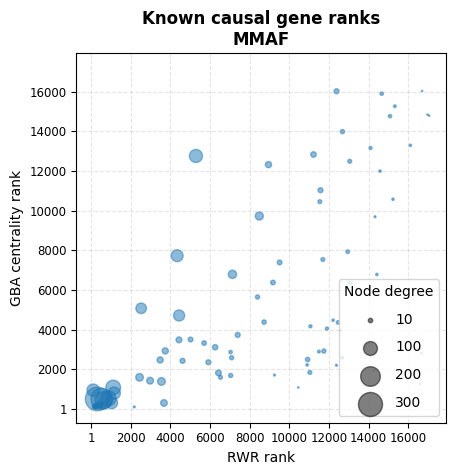

In [90]:
# compare GBA centrality rank vs RWR rank for each left-out genes, adjust point size by node degree
node_degrees = []
for gene in protein2rank_GBA:
    node_degrees.append(interactome.degree(gene))

matplotlib.pyplot.scatter(x=ranks_RWR, y=ranks_GBA, s=node_degrees, alpha=0.5)
matplotlib.pyplot.xlabel("RWR rank")
matplotlib.pyplot.ylabel("GBA centrality rank")

if PHENOTYPE in ["MMAF", "NOA", "OG", "PCD", "POF"]:
    matplotlib.pyplot.title(f"Known causal gene ranks\n{PHENOTYPE}", weight='bold', fontsize=12)
elif PHENOTYPE == "BC":
    matplotlib.pyplot.title(f"Known causal gene ranks\nbreast cancer", weight='bold', fontsize=12)
elif PHENOTYPE == "CC":
    matplotlib.pyplot.title(f"Known causal gene ranks\ncolon cancer", weight='bold', fontsize=12)
elif PHENOTYPE == "HYPCARD":
    matplotlib.pyplot.title(f"Known causal gene ranks\nhypertrophic cardiomyopathy", weight='bold', fontsize=12)
elif PHENOTYPE == "DILCARD":
    matplotlib.pyplot.title(f"Known causal gene ranks\ndilated cardiomyopathy", weight='bold', fontsize=12)

ticks  = numpy.arange(0, len(interactome), step=2000)
ticks[0] = 1
ticks = ticks[::-1]

matplotlib.pyplot.xticks(ticks, fontsize=8.5)
matplotlib.pyplot.yticks(ticks, fontsize=8.5)

matplotlib.pyplot.axis('square')

matplotlib.pyplot.grid(True, linestyle='--', which='major',
                   color='grey', alpha=0.2)

# add a legend for point size
for degree in [10, 100, 200, 300]:
    matplotlib.pyplot.scatter([], [], s=degree, c='k', alpha=0.5,
               label=str(degree))
matplotlib.pyplot.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Node degree', loc='lower right')

if SAVE_FIGURES:
    matplotlib.pyplot.savefig(FIGURES_DIR + f"{PHENOTYPE}_scatter_GBA_vs_RWR", dpi=1000)

In [91]:
ranks_GBA = []
ranks_RWR = []
node_degrees = []

# for phenotype in ["MMAF", "NOA", "HYPCARD", "DILCARD", "BC", "CC"]:
for phenotype in ["MMAF"]:
    LEAVE_ONE_OUT_RANKS_FILE = f"/home/kubicaj/GBA-output/{phenotype}/alpha{alpha}/ranks_LOO.tsv"
    LEAVE_ONE_OUT_RWR_RANKS_FILE = f"/home/kubicaj/GBA-centrality-validation/run_MultiXrank/{phenotype}/RWR_ranks_LOO.tsv"

    protein2rank_GBA = parse_GBA_ranks(LEAVE_ONE_OUT_RANKS_FILE)
    protein2rank_RWR = parse_RWR_ranks(LEAVE_ONE_OUT_RWR_RANKS_FILE)

    for gene in protein2rank_GBA:
        ranks_GBA.append(protein2rank_GBA[gene])
        ranks_RWR.append(protein2rank_RWR[gene])
        node_degrees.append(interactome.degree(gene))

assert len(ranks_GBA) == len(ranks_RWR)

In [92]:
rank_diff = []
negative_rank_degrees = []
positive_rank_degrees = []

for i in range(len(ranks_GBA)):
    diff = ranks_GBA[i] - ranks_RWR[i]
    rank_diff.append(abs(diff))

    if diff < 0:
        negative_rank_degrees.append(node_degrees[i])
    else:
        positive_rank_degrees.append(node_degrees[i])

print(f"absolute rank difference mean: {round(statistics.mean(rank_diff))}, median: {round(statistics.median(rank_diff))}")
print(f"negative rank degree mean: {round(statistics.mean(negative_rank_degrees))}, median: {round(statistics.median(negative_rank_degrees))}")
print(f"positive rank degree mean: {round(statistics.mean(positive_rank_degrees))}, median: {round(statistics.median(positive_rank_degrees))}")

absolute rank difference mean: 3643, median: 2464
negative rank degree mean: 19, median: 9
positive rank degree mean: 63, median: 46


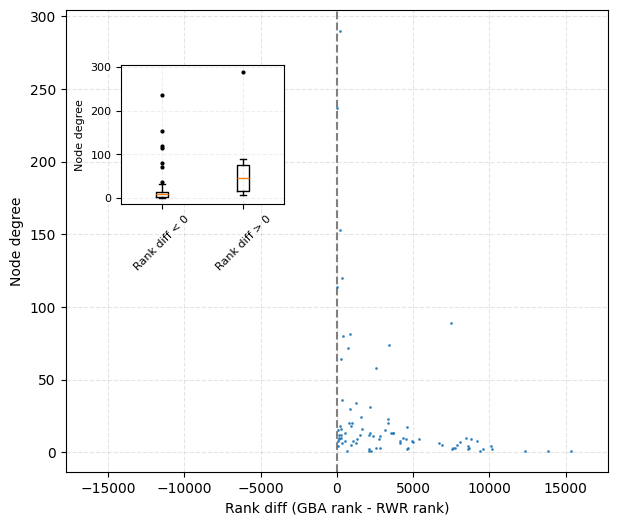

In [93]:
fig, ax = matplotlib.pyplot.subplots(figsize=(7, 6))

ax.scatter(x=rank_diff, y=node_degrees, s=1, alpha=0.8, zorder=3)
ax.set_xlim(-(len(interactome)), len(interactome))
ax.axvline(0, color='grey', linestyle='--', linewidth=1.5, zorder=2)

ax.set_xlabel("Rank diff (GBA rank - RWR rank)")
ax.set_ylabel("Node degree")

ax.grid(True, linestyle='--', which='major',
                   color='grey', alpha=0.2)

inset = inset_axes(ax, width="30%", height="30%", loc=2, borderpad=4)

inset.boxplot([negative_rank_degrees, positive_rank_degrees],
              flierprops=dict(marker='o', markersize=2, markerfacecolor='black'))
inset.set_xticklabels(["Rank diff < 0", "Rank diff > 0"], fontsize=8, rotation=45)
inset.set_ylabel("Node degree", fontsize=8)
inset.tick_params(axis='y', labelsize=8)

inset.grid(True, linestyle="--", alpha=0.2)
if SAVE_FIGURES:
    matplotlib.pyplot.savefig(FIGURES_DIR + f"all_rank_vs_deg_GBA_vs_RWR", dpi=300)